In [5]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

# 드라이버 경로 설정 (본인 환경에 맞게 수정)
service = Service(r"C:\chromedriver-win64\chromedriver-win64\chromedriver.exe")
options = Options()
driver = webdriver.Chrome(service=service, options=options)
driver.maximize_window()

# 1. 유튜브 채널명과 검색할 주제 입력
channel_name = input("유튜브 채널명 입력: ").strip()
search_topic = input("검색할 주제 입력: ").strip()

# 2. 유튜브 검색 결과에서 채널명 검색 후 접근
driver.get(f"https://www.youtube.com/results?search_query={channel_name}")
time.sleep(2)

try:
    # 채널 클릭 (여기서는 ID가 "text"인 요소를 클릭하는 기존 방식 사용)
    element = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, "text")))
    element.click()
    time.sleep(2)
except Exception as e:
    print("❌ 채널 클릭 실패:", e)

# 3. 채널 내 검색 수행 (주소 이동 방식 사용)
try:
    current_channel_url = driver.current_url
    channel_search_url = current_channel_url + "/search?query=" + search_topic
    driver.get(channel_search_url)
    time.sleep(3)
except Exception as e:
    print("❌ 채널 내 검색 실패:", e)

# 5. 영상 URL 수집 (스크롤 횟수를 5회로 제한)
url_list = []
last_height = driver.execute_script("return document.documentElement.scrollHeight")

for _ in range(5):  # 스크롤 횟수 조절 (필요에 따라 조정)
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight)")
    time.sleep(2)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

soup = BeautifulSoup(driver.page_source, "html.parser")
video_links = soup.select("a#thumbnail[href^='/watch']")

for tag in video_links:
    href = tag.get("href")
    if href:
        url_list.append("https://www.youtube.com" + href)

url_list = list(set(url_list))
print(f"\n✅ 수집된 영상 수: {len(url_list)}")

# 6. 각 영상에서 댓글 크롤링 (예시: 최대 5개 영상)
id_list = []
comment_list = []

for idx, video_url in enumerate(url_list):
    print(f"\n▶ {idx+1}번 영상: {video_url}")
    driver.get(video_url)
    time.sleep(3)
    
    # 댓글 영역이 로딩될 때까지 기다림 (댓글 컨테이너의 셀렉터: "ytd-comments")
    try:
        comment_container = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "ytd-comments"))
        )
        # 댓글 영역까지 스크롤
        driver.execute_script("arguments[0].scrollIntoView();", comment_container)
        time.sleep(3)
    except Exception as e:
        print("❌ 댓글 컨테이너 로딩 실패:", e)
    
    # 추가 스크롤: 일정 픽셀씩 반복적으로 스크롤하여 댓글 lazy load 유도
    scroll_pause_time = 2
    total_scrolls = 10
    for i in range(total_scrolls):
        driver.execute_script("window.scrollBy(0, 1000);")
        time.sleep(scroll_pause_time)

    # 유료 가입 배너(있을 경우) 닫기
    try:
        driver.find_element(By.CSS_SELECTOR, "#dismiss-button > a").click()
    except:
        pass

    # 댓글 파싱 (동적 요소 찾기로 진행)
    # 댓글은 'ytd-comment-thread-renderer' 요소 안에 있습니다.
    comment_threads = driver.find_elements(By.CSS_SELECTOR, "ytd-comment-thread-renderer")
    for thread in comment_threads:
        try:
            author = thread.find_element(By.CSS_SELECTOR, "#author-text span").text.strip()
            comment_text = thread.find_element(By.CSS_SELECTOR, "#content-text").text.strip()
            id_list.append(author)
            comment_list.append(comment_text)
        except Exception as e:
            print("댓글 파싱 중 오류 발생:", e)

# 7. 크롤링된 댓글 출력
print("\n📝 크롤링된 댓글:")
for author, comment in zip(id_list, comment_list):
    print(f"[{author}] {comment}")

driver.quit()


유튜브 채널명 입력:  sbs 뉴스
검색할 주제 입력:  연두색 번호판 제도



✅ 수집된 영상 수: 23

▶ 1번 영상: https://www.youtube.com/watch?v=cEDE3Esw3M4

▶ 2번 영상: https://www.youtube.com/watch?v=yy1RPhuZ2qE

▶ 3번 영상: https://www.youtube.com/watch?v=C3vJcjDKP6Y

▶ 4번 영상: https://www.youtube.com/watch?v=M2Ndi-o_u-k

▶ 5번 영상: https://www.youtube.com/watch?v=Y11uf8HoFPU
❌ 댓글 컨테이너 로딩 실패: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF6FC3B1F55+78133]
	GetHandleVerifier [0x00007FF6FC3B1FB0+78224]
	(No symbol) [0x00007FF6FC1791BA]
	(No symbol) [0x00007FF6FC1CF19D]
	(No symbol) [0x00007FF6FC1CF44C]
	(No symbol) [0x00007FF6FC2223D7]
	(No symbol) [0x00007FF6FC1F719F]
	(No symbol) [0x00007FF6FC21F21F]
	(No symbol) [0x00007FF6FC1F6F33]
	(No symbol) [0x00007FF6FC1C0358]
	(No symbol) [0x00007FF6FC1C10C3]
	GetHandleVerifier [0x00007FF6FC67BA8D+3001453]
	GetHandleVerifier [0x00007FF6FC675E72+2977874]
	GetHandleVerifier [0x00007FF6FC69497D+3103581]
	GetHandleVerifier [0x00007FF6FC3CC7EA+186826]
	GetHandleVerifier [0x00007FF6FC3D43FF+218591]
	GetHandleVerifier [0x00007FF6FC3B9D94+

In [6]:
comment_list

['회사명 양쪽문 80%크기로 박아넣도록 법제화 해야됨. 대체 뭐하는 회사길래 슈퍼카를 법인으로함ㅋㅋㅋ',
 '왜 8천만원?   모든 법인차는 연두색 번호판을 달게 하지',
 '음주운전 차량 번호판도 식별 가능하게 바꿔라.. 경찰들이 순찰하다가 수시로 세워서 음주단속할 수 있게',
 '기존 법인차량도 모두 번호판 구분해라',
 '모든 법인차 소유차량은 색이 달라야 하고 \n유독 많은 슈퍼카 법인들은 세무조사 나가야 한다.\n법인에서 의전차량 빼고 람보르기니를 살이유가 없잖냐?',
 '그냥 법인 고가 차량도 인터넷 a/s기사 경차처럼 어느 회산지 떡칠해서 사적사용 눈치보게 만들어야함\n아얘 차 옆문에다가 큼지막하게 (주)ㅇㅇㅇㅇ 이런식으로 쓰는거 의무화하자',
 '법인차량은 꼭 의무로 차량옆면. 및 본넷, 트렁크에 회사명 의무로 크게 달기...요런게 좋은듯 한데...',
 '이건 작년에 시행한다고 하자마자 했어야했음.. 올해 되기전에 미리 구입했다고 뉴스에 나올정도였는데 효과볼려면 기존에 법인 차량들한테 전부 적용해야 함',
 '돈 많으면 개인 명의로 사서 타...',
 '법인차는 택시처럼 "법인표시등" 의무화 하자 그래야 한눈에 법인차인지 개인차인지 알수 있지',
 '가격에 상관없이 모든 법인차량에 연두색 번호판을 부착하도록 해야 한다.',
 '7천9백 9십만원에  맞춰준다 딜러가 ..  정책을 새울려면  정해진금액  맞추지말고 적용해라 .',
 '익숙해지면 다시 원상태로 돌아옴',
 '번호판에 추가로 회사이름 로고스티커 규격사이즈 정해서 붙이고 다니게 하면 딱인데 ㅋㅋㅋ 어지간해선 업무 이외에 쪽팔려서 못타지',
 '법인차가 8천이 넘을 이유가 있나? 6천까지만 법인차 인정해주면 되자나 봐주는것도 적당히 해라!!!',
 '번호판보다 회사이름을 넣는것이 제일 좋은 방법임\n100% 효과있음\n연두색 번호판은 조금 약함',
 '벤츠 베엠더블우 아우디 뭐 접대용으로 살수 있다고 쳐도 도대체 슢퍼카는 법인차량으로 왜 하는거냐?? 그게 업무적으로 도움이되나 슈퍼카 이

In [7]:
import pandas as pd

In [9]:
df = pd.DataFrame(comment_list)

In [10]:

# CSV 파일로 저장
df.to_csv('comment.csv', index=False, encoding='utf-8')


In [ ]:
#######################################################################################################################################

In [7]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
stopwords.add("...")
stopwords.add("ㅎㅎ")
stopwords.add("..")
stopwords.add(",,,")
stopwords.add("ㅋㅋ")
stopwords.add("ㅋㅋㅋ")
stopwords.add("ㅋㅋㅋㅋ")
stopwords.add("ㅋㅋㅋㅋㅋ")
              

In [8]:
stopwords

{',,,',
 '..',
 '...',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwis

In [10]:
with open("stopwords.txt", encoding="utf-8") as f:
    stopwords = set(f.read().splitlines())

In [12]:
import pandas as pd

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# CSV 파일을 pandas 데이터프레임으로 읽어옴
# df = pd.read_csv('파일이름.csv',encoding='utf-8')
df = pd.DataFrame(comment_list,columns=['댓글 내용'])

# 댓글 내용이 저장된 컬럼 선택
comment_col = '댓글 내용'
comment_list = df[comment_col].tolist()
new_list = []
for x in comment_list:
    new_list.append(str(x))

# 모든 댓글 내용을 하나의 문자열로 결합
text = ' '.join(new_list)

In [16]:
text

'고가든 아니든 모두 연두색 번호판을 달도록 해야죠  특히 관용차는 가격과 무관하게 100% 법인차면 모두 연두색 하면 되는거지 굳이 8천 이상 가격에만 해당시키는 게  이해불가. 애초에 법인차를 개인용도로 사용하는 걸 막으려고 하는 게 목적 아니었어? 설마 가진사람 부러워서 만든 법은 아닐거 아냐? 심지어 소급적용 ㅋ 법인차를 끌면 안된다는 말들이 많은데... 그럼 법인의 주인은 누구인가?  주주가 주인아님?  근데 우리나라 중소기업이나 중견기업들은 대부분이 오너들이 거의모든 지분을 가지고있음.   그럼 그 법인의 주인은 오너들아님?? 뭔가 세법 1도 모르는 애들이 걍 열등감에 쩔어서 법인 슈퍼카나 고급차만 보면 ㅂㄷㅂㄷ하는데\n법인차량을 사적으로 이용하는건 불법이 아니란다.\n아빠차 아들이 운전해도 법적으로 처벌 안받지? 다만 아빠 명의의 보험이면 아들이 사고 났을때 보험 적용은 안되지? 그거랑 같은거야.\n법인차량을 사적으로 이용하든 , 아니면 법인관계자 이외에 사람이 운전하든 그거 자체는 불법이 아니란다.단지 법인의 활동 이외의 목적으로 이용하면서 , 그걸 비용처리하거나 , 법인관계자이외의 사람이 운전을 하면서 보험처리를 하거나 이런것들이 위반이란다. 바꾸어 말하면 법인명으로만 차를 출고하고 ,법인의 비용처리를 안하면 , 그차로 클럽을 가든 , 사모가 장을 보러 가든 ,  법적으로 문제없어.\n 그리고 보험도 법인차는 법인관계자한정 or 누구나로 선택해서 가입할수 있어. 누구나로 선택하면 \n법인관계자 이외 아무나 타도 상관없지만 , 비용처리가 안된단다. 당연히 위법도 아니고.\n뭘 잘 알지도 못하면서 ,,불법이나 처벌이니 세법 1도 모르는 애들이 많은데 , 이건 현실적으로  처벌을 하려는 입법이 아니란다. 걍 일반인들에게 위화감을 줄이려는게 목적이지. 회사에서 실제 일하지 않는 가족들이 타는건 정말 문제지만.\n어차피 고가 법인차량이면 최소 임원급일텐데\n주말이나 출퇴근이 정해져 있나\n장소도 사람 만나는 일이 많은데 \n우리나라 경제와 고용창출에 이

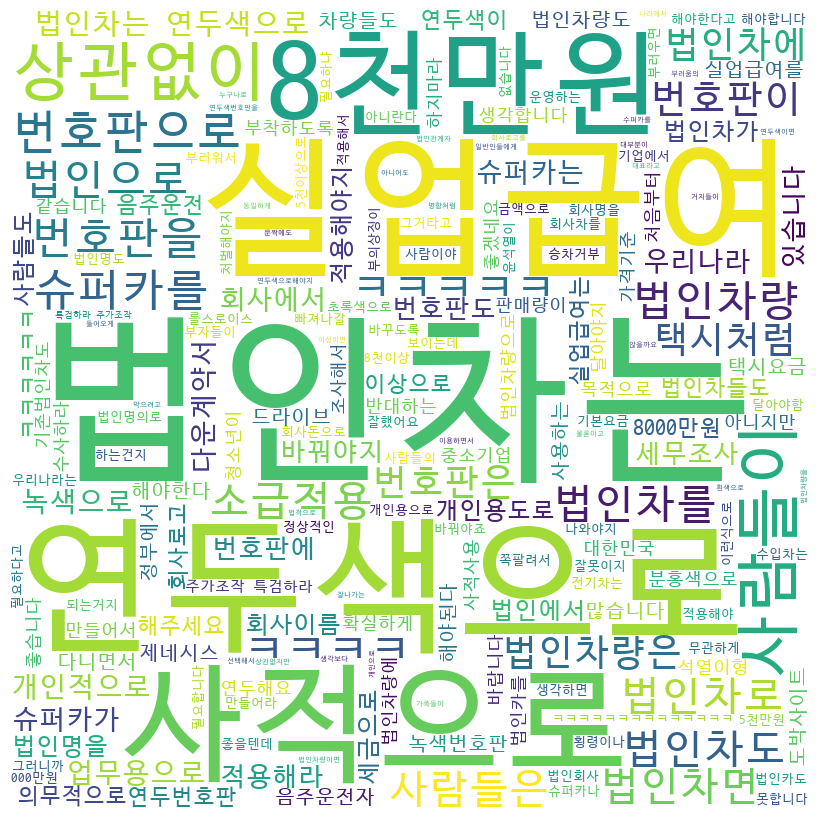

In [21]:
# 워드 클라우드 생성
font_path = r"C:\Users\erety\Downloads\D2Coding-Ver1.3.2-20180524\D2Coding\D2Coding-Ver1.3.2-20180524.ttf"
wordcloud = WordCloud(font_path=font_path,width=800, height=800,
                      background_color='white',stopwords=stopwords, min_word_length=4).generate(text)

# 단어의 빈도 계산
wordcloud.generate_from_frequencies(wordcloud.process_text(text.lower()))
word_freq = wordcloud.process_text(text.lower())

# 워드 클라우드 출력
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

# 파일로 저장
plt.savefig('wordcloud.png')